<a href="https://colab.research.google.com/github/Devansh-0/DBpedia-BERT-Analysis/blob/main/DBpedia_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DBpedia Exploratory Data Analysis using BERT

---

This EDA is based on the DBpedia data. The test and train data contain 70,000 and 560,000 data unique values respectrively.<br />

 Due to the huge size of the dataset and the limited hardware capabilities, this analysis is performed on a portion of the entire dataset.  <br /> 
The dataset consists of 14 classes. All the identities/ names are categorized into one of these 14 classes. (for eg: Building, Vehicle, Place etc.)
For training, 25,000 values were considered, distributed among 5 classes equally. The test was done on 500 values (100 each).  <BR />

The time taken by the model to train was around 1 hour 15 minutes.







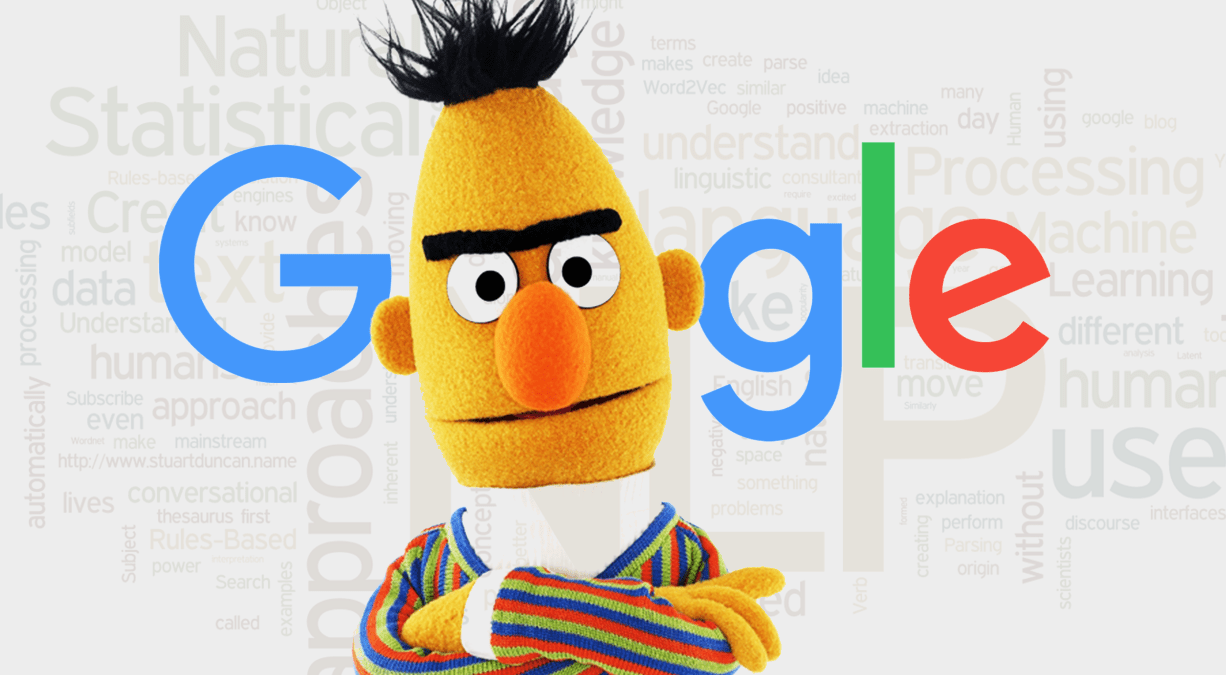

## Setting up the Environment
For the analysis to execute correctly, a few steps were required to ensure the environment settings were favorable.



*   The Runtime was reset to GPU, since the training will be done on a large neural network. 
*   Prerequisite dependencies were installed on the Colab instance.



> After setting the Runtime to GPU, I checked which version was assigned and whether it was fuctional or not. For the execution, I was given the Tesla T4 by Nvidia. Important libraries were then installed and the tenseorflow functionality was utilized.












In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install transformers

## Accessing the Data

After setting up the environment, I then downloaded the DBpedia Dataset from the link provided. The files were saved on Google Drive for easy access. Link to the files used is provided: 


Due to the enormous size of the dataset, a small portion of it was utilized. To make the work easier, random 100 samples of each class were chosen from the five classes and moved to a separate CSV file for testing purposes. 

Primarily, the work was done on the description and the class type. All the values were then encoded manually, since the classes were not that diverse.

In [ ]:
import pandas as pd

df_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML Datasets/DBpedia.csv/dbpedia_csv/test.csv')

df_csv = df_csv.drop(labels=range(20000, 25000), axis=0)
df_csv = df_csv.drop(labels=range(30000, 70000), axis=0)

print('Number of training sentences: {:,}\n'.format(df_csv.shape[0]))
df_csv.loc[df_csv.ClassType == 6].sample(4)[['Description', 'ClassType']]

print("\n The Unique Values are:\n ", df_csv["ClassType"].value_counts())

print("Encoding the ClassType, We get: ")

cleanup_nums = {"ClassType":     {1: 0, 2: 1, 3:2, 4:3, 6:4}}
df_csv = df_csv.replace(cleanup_nums)

print(df_csv.head())


description = df_csv.Description.values
class_type = df_csv.ClassType.values



Number of training sentences: 25,000


 The Unique Values are:
  6    5000
4    5000
3    5000
2    5000
1    5000
Name: ClassType, dtype: int64
Encoding the ClassType, We get: 
   ClassType  ...                                        Description
0          0  ...   TY KU /taɪkuː/ is an American alcoholic bever...
1          0  ...   OddLot Entertainment founded in 2001 by longt...
2          0  ...   Henkel AG & Company KGaA operates worldwide w...
3          0  ...   The GOAT Store (Games Of All Type Store) LLC ...
4          0  ...   RagWing Aircraft Designs (also called the Rag...

[5 rows x 3 columns]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Tokenization Process
To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary. 

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Print the original sentence.
print(' Original: ', description[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(description[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(description[0])))

 Original:   TY KU /taɪkuː/ is an American alcoholic beverage company that specializes in sake and other spirits. The privately-held company was founded in 2004 and is headquartered in New York City New York. While based in New York TY KU's beverages are made in Japan through a joint venture with two sake breweries. Since 2011 TY KU's growth has extended its products into all 50 states.
Tokenized:  ['ty', 'ku', '/', 'ta', '##ɪ', '##ku', '##ː', '/', 'is', 'an', 'american', 'alcoholic', 'beverage', 'company', 'that', 'specializes', 'in', 'sake', 'and', 'other', 'spirits', '.', 'the', 'privately', '-', 'held', 'company', 'was', 'founded', 'in', '2004', 'and', 'is', 'headquartered', 'in', 'new', 'york', 'city', 'new', 'york', '.', 'while', 'based', 'in', 'new', 'york', 'ty', 'ku', "'", 's', 'beverages', 'are', 'made', 'in', 'japan', 'through', 'a', 'joint', 'venture', 'with', 'two', 'sake', 'brewer', '##ies', '.', 'since', '2011', 'ty', 'ku', "'", 's', 'growth', 'has', 'extended', 'its', '

In [ ]:
max_len = 0

# For every sentence...
for desc in description:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(desc, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  416


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for desc in description:
    encoded_dict = tokenizer.encode_plus(
                        desc,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 416,           # Pad & truncate all sentences.                             
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
class_type = torch.tensor(class_type)

# Print sentence 0, now as a list of IDs.
print('Original: ', description[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:   TY KU /taɪkuː/ is an American alcoholic beverage company that specializes in sake and other spirits. The privately-held company was founded in 2004 and is headquartered in New York City New York. While based in New York TY KU's beverages are made in Japan through a joint venture with two sake breweries. Since 2011 TY KU's growth has extended its products into all 50 states.
Token IDs: tensor([  101,  5939, 13970,  1013, 11937, 29685,  5283, 23432,  1013,  2003,
         2019,  2137, 14813, 19645,  2194,  2008, 16997,  1999,  8739,  1998,
         2060,  8633,  1012,  1996,  9139,  1011,  2218,  2194,  2001,  2631,
         1999,  2432,  1998,  2003,  9403,  1999,  2047,  2259,  2103,  2047,
         2259,  1012,  2096,  2241,  1999,  2047,  2259,  5939, 13970,  1005,
         1055, 21705,  2024,  2081,  1999,  2900,  2083,  1037,  4101,  6957,
         2007,  2048,  8739, 18710,  3111,  1012,  2144,  2249,  5939, 13970,
         1005,  1055,  3930,  2038,  3668,  2049,  368

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## Training and Validation Split
The dataset will now be split for training and validation. 90% for training and the remaining 10% for validation.

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, class_type)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

22,500 training samples
2,500 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## Training the Classification Model

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

The huggingface PyTorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.

We will use the **BertForSequenceClassification** for our classification task.


In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 5, # The number of output labels--5 for binary classification.  
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
 
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import random
import numpy as np

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

   
        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    
    # VALIDATION

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    704.    Elapsed: 0:00:55.
  Batch    80  of    704.    Elapsed: 0:01:52.
  Batch   120  of    704.    Elapsed: 0:02:49.
  Batch   160  of    704.    Elapsed: 0:03:45.
  Batch   200  of    704.    Elapsed: 0:04:42.
  Batch   240  of    704.    Elapsed: 0:05:38.
  Batch   280  of    704.    Elapsed: 0:06:35.
  Batch   320  of    704.    Elapsed: 0:07:31.
  Batch   360  of    704.    Elapsed: 0:08:28.
  Batch   400  of    704.    Elapsed: 0:09:25.
  Batch   440  of    704.    Elapsed: 0:10:21.
  Batch   480  of    704.    Elapsed: 0:11:18.
  Batch   520  of    704.    Elapsed: 0:12:14.
  Batch   560  of    704.    Elapsed: 0:13:11.
  Batch   600  of    704.    Elapsed: 0:14:07.
  Batch   640  of    704.    Elapsed: 0:15:04.
  Batch   680  of    704.    Elapsed: 0:16:00.

  Average training loss: 0.10
  Training epcoh took: 0:16:33

Running Validation...
  Accuracy: 0.99
  Validation Loss: 0.03
  Validation took: 0:00:39

====

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.


# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,9.88e-02,0.03,0.99,0:16:33,0:00:39
2,1.49e-02,0.03,0.99,0:16:35,0:00:39
3,6.34e-03,0.02,0.99,0:16:33,0:00:39
4,2.84e-03,0.02,0.99,0:16:33,0:00:39


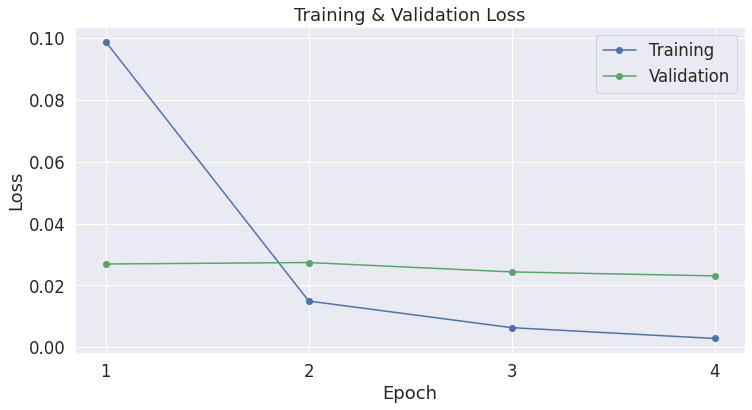

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='dark')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Performance on Test Set

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df_csv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML Datasets/DBpedia.csv/dbpedia_csv/DBpedia 3.0 test.csv")

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_csv.shape[0]))
cleanup_nums = {"ClassType":     {1: 0, 2: 1, 3:2, 4:3, 6:4}}
df_csv = df_csv.replace(cleanup_nums)
df_csv.head()

# Create sentence and label lists
Description = df_csv.Description.values
ClassType = df_csv.ClassType.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for desc in Description:

    encoded_dict = tokenizer.encode_plus(
                        desc,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 420,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(ClassType)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 500



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 500 test sentences...
    DONE.


## Final Results

In [ ]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_curve


The Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       100
           1       1.00      0.96      0.98       100
           2       0.99      0.99      0.99       100
           3       0.98      1.00      0.99       100
           4       1.00      1.00      1.00       100

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500

The confusion Matrix:
  [[ 98   0   1   1   0]
 [  4  96   0   0   0]
 [  0   0  99   1   0]
 [  0   0   0 100   0]
 [  0   0   0   0 100]]

 The accurracy score is 0.986


 The Heatmap of the final result : 



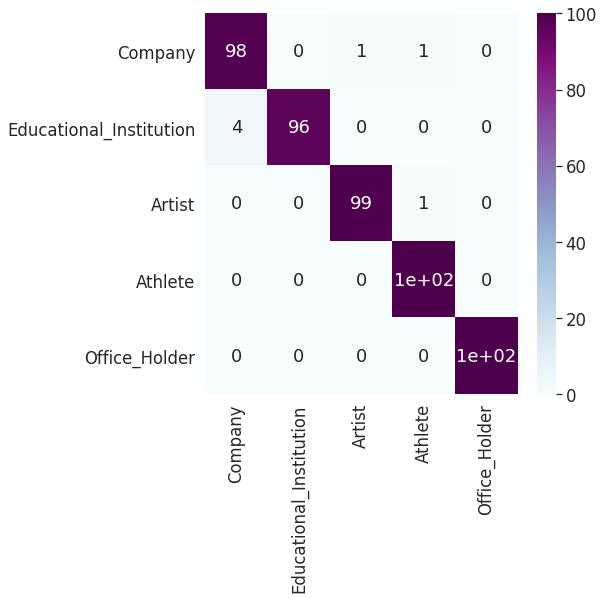

In [ ]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = classification_report(flat_true_labels, flat_predictions)
XXV = confusion_matrix(flat_true_labels, flat_predictions)

print("The Classification Report: \n", mcc)
print("The confusion Matrix:\n ",XXV)
print("\n The accurracy score is" , accuracy_score(flat_true_labels, flat_predictions))

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array =   [[ 98  , 0  , 1 ,  1 ,  0],
 [  4 , 96  , 0  , 0  , 0],
 [  0  , 0 , 99  , 1 ,  0],
 [  0   ,0   ,0 ,100  , 0],
 [  0  , 0  , 0  , 0 ,100]]
X= ['Company', 'Educational_Institution', 'Artist', 'Athlete', 'Office_Holder' ]

print("\n\n The Heatmap of the final result : \n")
df_cm = pd.DataFrame(array, index = [i for i in X],
                  columns = [i for i in X])
plt.figure(figsize = (7,7))
sn.heatmap(df_cm, annot=True, cmap="BuPu")



## We get the final accuracy score of **98%**.


                precision    recall  f1-score   support

           0       0.96      0.98      0.97       100
           1       1.00      0.96      0.98       100
           2       0.99      0.99      0.99       100
           3       0.98      1.00      0.99       100
           4       1.00      1.00      1.00       100

    accuracy                           0.99       500              

 

# Improvements which can made

98% accuracy is a really good score. Some hyperparameter tuning may tighten the model more, but we risk overfitting at that point. The major optimisation can be done to the **Training Time**.

The number of epochs can be recalculated. It was noticed that there are no  further improvements in the  error or accuracy beyond a defined threshold. Considering that, number of epochs can be reduced.